In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import (
    Embedding, GlobalAveragePooling1D, Dense,
    Dropout, Bidirectional, LSTM, Conv1D, GlobalMaxPooling1D, SimpleRNN, GRU
)


In [3]:
df = pd.read_csv("../FoodFactsCleaned.csv")

In [4]:
TEXT_COLS = [
    "brand_cleaned",
    "allergens_cleaned",
    "ingredients_text_cleaned",
    "countries_cleaned",
    "additives_cleaned",
]

In [5]:

# Concatenate into a single text field per product
df["text_concat"] = df[TEXT_COLS].fillna("").agg(" ".join, axis=1)

In [6]:
TARGET_COL = "nutriscore_letter"  

In [7]:
X_text = df["text_concat"]
y = df[TARGET_COL]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X_text,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train size:", len(X_train), "Test size:", len(X_test))


Train size: 4110 Test size: 1028


In [9]:

def evaluate_model(name, y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1_macro = f1_score(y_true, y_pred, average="macro")
    print(f"\n{name}")
    print("-" * len(name))
    print(f"Accuracy:  {acc:.4f}")
    print(f"Macro F1:  {f1_macro:.4f}")
    print("\nClassification report:")
    print(classification_report(y_true, y_pred))
    print("=" * 80)

In [10]:
# Store results
results = []

def log_result(name, y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1_macro = f1_score(y_true, y_pred, average="macro")
    print(f"\n{name}")
    print("-" * len(name))
    print(f"Accuracy:  {acc:.4f}")
    print(f"Macro F1:  {f1_macro:.4f}")
    print("\nClassification report:")
    print(classification_report(y_true, y_pred))
    print("=" * 80)
    results.append({
        "model": name,
        "accuracy": acc,
        "macro_f1": f1_macro
    })

# PATH A: TF-IDF 

In [11]:
vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),
    min_df=5,
    max_features=30000  
)

In [12]:
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [19]:
log_reg = LogisticRegression(
    max_iter=2000,
    n_jobs=-1,
    multi_class="multinomial",
    class_weight="balanced"
)

In [20]:
log_reg.fit(X_train_tfidf, y_train)
y_pred_lr = log_reg.predict(X_test_tfidf)
log_result("Path A1: TF-IDF + LogisticRegression", y_test, y_pred_lr)

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Path A1: TF-IDF + LogisticRegression
------------------------------------
Accuracy:  0.5710
Macro F1:  0.5665

Classification report:
              precision    recall  f1-score   support

           0       0.58      0.57      0.58       193
           1       0.57      0.54      0.55       197
           2       0.49      0.52      0.51       210
           3       0.50      0.48      0.49       197
           4       0.69      0.72      0.70       231

    accuracy                           0.57      1028
   macro avg       0.57      0.57      0.57      1028
weighted avg       0.57      0.57      0.57      1028



In [21]:

svm_clf = LinearSVC(
    C=1.0,
    class_weight="balanced"
)
svm_clf.fit(X_train_tfidf, y_train)
y_pred_svm = svm_clf.predict(X_test_tfidf)
log_result("Path A2: TF-IDF + LinearSVC", y_test, y_pred_svm)


Path A2: TF-IDF + LinearSVC
---------------------------
Accuracy:  0.5885
Macro F1:  0.5827

Classification report:
              precision    recall  f1-score   support

           0       0.62      0.59      0.60       193
           1       0.59      0.55      0.57       197
           2       0.50      0.53      0.51       210
           3       0.52      0.48      0.50       197
           4       0.70      0.77      0.73       231

    accuracy                           0.59      1028
   macro avg       0.58      0.58      0.58      1028
weighted avg       0.59      0.59      0.59      1028



In [22]:
# ---- TF-IDF + (Neural Network) ----

# Convert sparse to dense for Keras (be careful with very high dim)
X_train_dense = X_train_tfidf.toarray()
X_test_dense = X_test_tfidf.toarray()

# Encode labels as integers for Keras
le_tfidf = LabelEncoder()
y_train_enc = le_tfidf.fit_transform(y_train)
y_test_enc = le_tfidf.transform(y_test)
num_classes = len(le_tfidf.classes_)

input_dim = X_train_dense.shape[1]

def build_tfidf_mlp(input_dim, num_classes):
    model = Sequential([
        Dense(256, activation="relu", input_shape=(input_dim,)),
        Dropout(0.4),
        Dense(128, activation="relu"),
        Dropout(0.4),
        Dense(num_classes, activation="softmax")
    ])
    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

In [24]:
from tensorflow.keras.callbacks import EarlyStopping


In [25]:
mlp_tfidf = build_tfidf_mlp(input_dim, num_classes)

es = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

history_mlp = mlp_tfidf.fit(
    X_train_dense,
    y_train_enc,
    validation_split=0.2,
    epochs=20,
    batch_size=64,
    callbacks=[es],
    verbose=1
)

Epoch 1/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.3373 - loss: 1.4907 - val_accuracy: 0.5243 - val_loss: 1.2373
Epoch 2/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6055 - loss: 1.0436 - val_accuracy: 0.6083 - val_loss: 0.9457
Epoch 3/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7421 - loss: 0.7042 - val_accuracy: 0.6071 - val_loss: 0.9182
Epoch 4/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8504 - loss: 0.4627 - val_accuracy: 0.6229 - val_loss: 0.9813
Epoch 5/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9088 - loss: 0.3059 - val_accuracy: 0.6119 - val_loss: 1.0661
Epoch 6/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9383 - loss: 0.2052 - val_accuracy: 0.6217 - val_loss: 1.1966


In [26]:
y_proba_mlp = mlp_tfidf.predict(X_test_dense)
y_pred_mlp_enc = np.argmax(y_proba_mlp, axis=1)
y_pred_mlp = le_tfidf.inverse_transform(y_pred_mlp_enc)

log_result("Path A3: TF-IDF + Custom MLP", y_test, y_pred_mlp)


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Path A3: TF-IDF + Custom MLP
----------------------------
Accuracy:  0.5807
Macro F1:  0.5753

Classification report:
              precision    recall  f1-score   support

           0       0.64      0.57      0.60       193
           1       0.56      0.54      0.55       197
           2       0.48      0.50      0.49       210
           3       0.51      0.49      0.50       197
           4       0.70      0.77      0.73       231

    accuracy                           0.58      1028
   macro avg       0.58      0.58      0.58      1028
weighted avg       0.58      0.58      0.58      1028



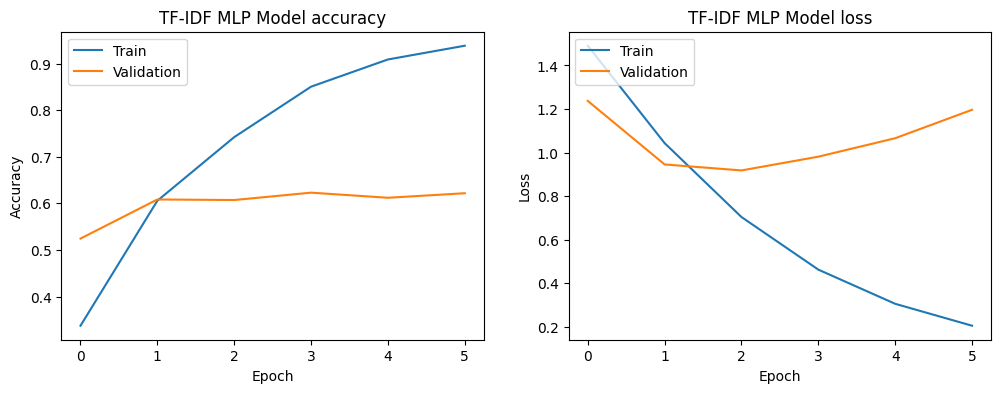

In [27]:
# Plot training & validation accuracy values for TF-IDF MLP
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_mlp.history['accuracy'])
plt.plot(history_mlp.history['val_accuracy'])
plt.title('TF-IDF MLP Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_mlp.history['loss'])
plt.plot(history_mlp.history['val_loss'])
plt.title('TF-IDF MLP Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Show the plots
plt.show()

# PATH B: Neural Text Model

In [28]:
# ---- Encode labels to integers (for neural net) ----
le_seq = LabelEncoder()
y_train_seq_enc = le_seq.fit_transform(y_train)
y_test_seq_enc = le_seq.transform(y_test)
num_classes_seq = len(le_seq.classes_)


In [29]:
# ---- 2) Tokenize & pad sequences ----
MAX_WORDS = 30000   # vocab size
MAX_LEN = 200       # max tokens per sample

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding="post", truncating="post")
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding="post", truncating="post")

In [30]:
vocab_size = min(MAX_WORDS, len(tokenizer.word_index) + 1)

In [31]:
# ---- 3) Build the model ----
def build_baseline_text_model(vocab_size, max_len, num_classes):
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len),
        GlobalAveragePooling1D(),
        Dropout(0.3),
        Dense(64, activation="relu"),
        Dropout(0.3),
        Dense(num_classes, activation="softmax"),
    ])
    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

In [37]:
def build_baseline_Max_text_model(vocab_size, max_len, num_classes):
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len),
        GlobalMaxPooling1D(),
        Dropout(0.3),
        Dense(64, activation="relu"),
        Dropout(0.3),
        Dense(num_classes, activation="softmax"),
    ])
    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

In [46]:
def build_rnn_text_model(vocab_size, max_len, num_classes):
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len),
        SimpleRNN(64, return_sequences=False),
        Dropout(0.4),
        Dense(64, activation="relu"),
        Dropout(0.4),
        Dense(num_classes, activation="softmax"),
    ])
    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model



In [33]:
def build_cnn_text_model(vocab_size, max_len, num_classes):
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len),
        Conv1D(filters=128, kernel_size=5, activation="relu"),
        GlobalMaxPooling1D(),
        Dropout(0.4),
        Dense(64, activation="relu"),
        Dropout(0.4),
        Dense(num_classes, activation="softmax"),
    ])
    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

In [34]:
es_seq = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

In [35]:
# ---- Baseline Embedding + GlobalAveragePooling ----
model_b1 = build_baseline_text_model(vocab_size, MAX_LEN, num_classes_seq)

history_b1 = model_b1.fit(
    X_train_pad,
    y_train_seq_enc,
    validation_split=0.2,
    epochs=30,
    batch_size=64,
    
    verbose=1
)

y_proba_b1 = model_b1.predict(X_test_pad)
y_pred_b1_enc = np.argmax(y_proba_b1, axis=1)
y_pred_b1 = le_seq.inverse_transform(y_pred_b1_enc)

log_result("Embedding + GlobalAveragePooling", y_test, y_pred_b1)

Epoch 1/30


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.2302 - loss: 1.6079 - val_accuracy: 0.3260 - val_loss: 1.5960
Epoch 2/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2889 - loss: 1.5793 - val_accuracy: 0.2956 - val_loss: 1.5537
Epoch 3/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3169 - loss: 1.5226 - val_accuracy: 0.3601 - val_loss: 1.4719
Epoch 4/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3595 - loss: 1.4403 - val_accuracy: 0.3589 - val_loss: 1.3929
Epoch 5/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3811 - loss: 1.3775 - val_accuracy: 0.4246 - val_loss: 1.3155
Epoch 6/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4276 - loss: 1.3082 - val_accuracy: 0.4380 - val_loss: 1.2615
Epoch 7/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4638 - loss: 1.2569 - val_accuracy: 0.4769 - val_loss: 1.2247
Epoch 8/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4659 - loss: 1.2208 - val_accuracy: 0.4745 - val_loss: 1.2128
Epo

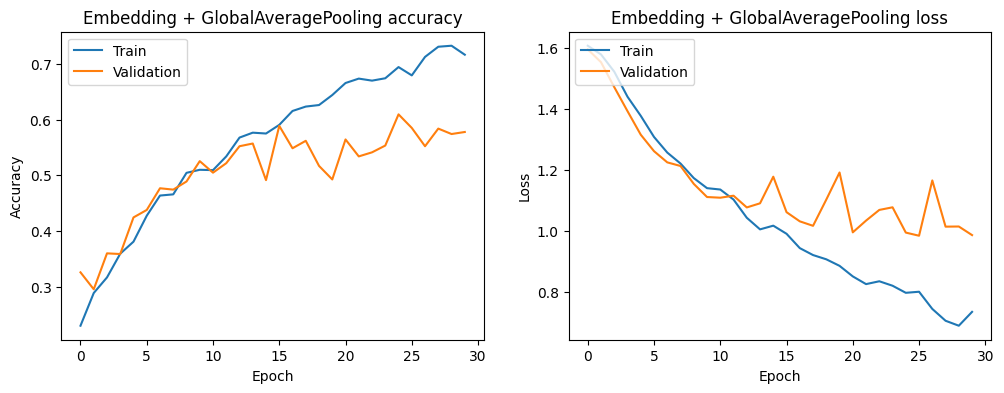

In [36]:
# Plot training & validation accuracy values for Baseline model
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_b1.history['accuracy'])
plt.plot(history_b1.history['val_accuracy'])
plt.title('Embedding + GlobalAveragePooling accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_b1.history['loss'])
plt.plot(history_b1.history['val_loss'])
plt.title('Embedding + GlobalAveragePooling loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [41]:
# ---- Baseline Embedding + GlobalMaxPooling ----
model_b12 = build_baseline_Max_text_model(vocab_size, MAX_LEN, num_classes_seq)

history_b1 = model_b1.fit(
    X_train_pad,
    y_train_seq_enc,
    validation_split=0.2,
    epochs=30,
    batch_size=64,

    verbose=1
)

y_proba_b1 = model_b1.predict(X_test_pad)
y_pred_b1_enc = np.argmax(y_proba_b1, axis=1)
y_pred_b1 = le_seq.inverse_transform(y_pred_b1_enc)

log_result("Embedding + GlobalMaxPooling", y_test, y_pred_b1)

Epoch 1/30
16/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9284 - loss: 0.2119

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9288 - loss: 0.2012 - val_accuracy: 0.6265 - val_loss: 1.4933
Epoch 2/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8890 - loss: 0.3012 - val_accuracy: 0.6192 - val_loss: 1.4325
Epoch 3/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9191 - loss: 0.2265 - val_accuracy: 0.6156 - val_loss: 1.4301
Epoch 4/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9221 - loss: 0.2101 - val_accuracy: 0.6204 - val_loss: 1.5022
Epoch 5/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9361 - loss: 0.1869 - val_accuracy: 0.6229 - val_loss: 1.4748
Epoch 6/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9170 - loss: 0.2264 - val_accuracy: 0.5499 - val_loss: 1.8756
Epoch 7/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9136 - loss: 0.2544 - val_accuracy: 0.6034 - val_loss: 1.6387
Epoch 8/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9197 - loss: 0.2277 - val_accuracy: 0.5900 - val_loss: 1.6589
Epo

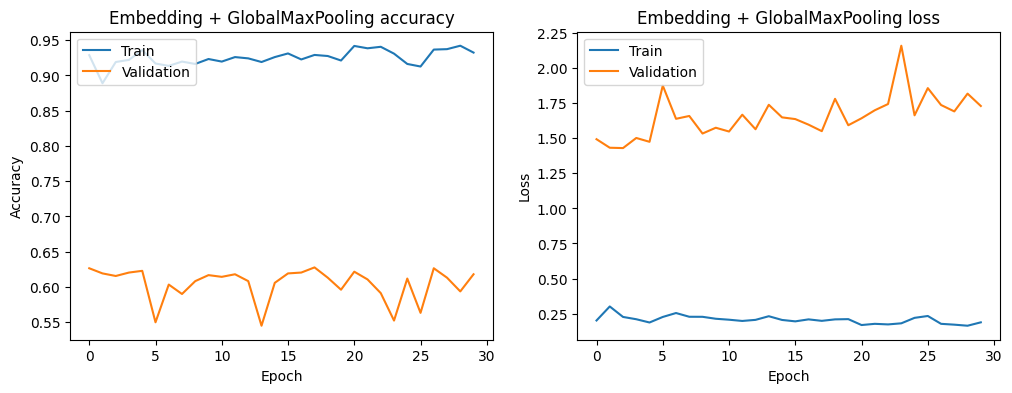

In [42]:
# Plot training & validation accuracy values for Baseline model
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_b1.history['accuracy'])
plt.plot(history_b1.history['val_accuracy'])
plt.title('Embedding + GlobalMaxPooling accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_b1.history['loss'])
plt.plot(history_b1.history['val_loss'])
plt.title('Embedding + GlobalMaxPooling loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [43]:
# ---- CNN-based text model (TextCNN-style) ----

model_b3 = build_cnn_text_model(vocab_size, MAX_LEN, num_classes_seq)

history_b3 = model_b3.fit(
    X_train_pad,
    y_train_seq_enc,
    validation_split=0.2,
    epochs=15,
    batch_size=64,
    callbacks=[es_seq],
    verbose=1
)

y_proba_b3 = model_b3.predict(X_test_pad)
y_pred_b3_enc = np.argmax(y_proba_b3, axis=1)
y_pred_b3 = le_seq.inverse_transform(y_pred_b3_enc)

log_result("Path B3: Embedding + Conv1D", y_test, y_pred_b3)

Epoch 1/15


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.2819 - loss: 1.5709 - val_accuracy: 0.3966 - val_loss: 1.4708
Epoch 2/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4158 - loss: 1.3723 - val_accuracy: 0.5195 - val_loss: 1.2260
Epoch 3/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5119 - loss: 1.1864 - val_accuracy: 0.5523 - val_loss: 1.0998
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Path B3: Embedding + Conv1D
---------------------------
Accuracy:  0.3638
Macro F1:  0.2835

Classification report:
              precision    recall  f1-score   support

           0       0.54      0.27      0.36       193
           1       0.63      0.09      0.15       197
           2       0.25      0.55      0.35       210
           3       0.00      0.00      0.00       197
           4       0.43      0.82      0.56       231

    accuracy                           0.36      1028
   macro avg       0.37      0.35      0.28      1028
weighted avg       0.37      0.36      0

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

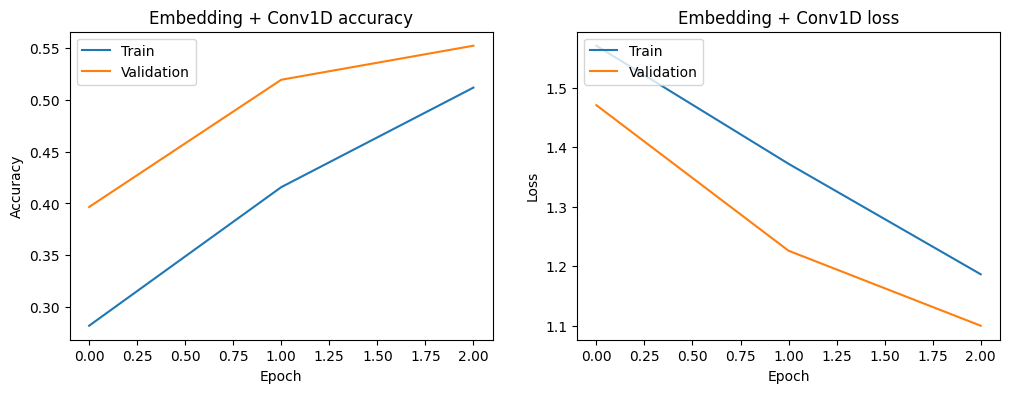

In [44]:
# Plot training & validation accuracy values for CNN model
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_b3.history['accuracy'])
plt.plot(history_b3.history['val_accuracy'])
plt.title('Embedding + Conv1D accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_b3.history['loss'])
plt.plot(history_b3.history['val_loss'])
plt.title('Embedding + Conv1D loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [52]:
# ---- RNN model – Embedding + Bidirectional LSTM ----

model_b2 = build_rnn_text_model(vocab_size, MAX_LEN, num_classes_seq)

history_b2 = model_b2.fit(
    X_train_pad,
    y_train_seq_enc,
    validation_split=0.2,
    epochs=30,
    batch_size=200,
    callbacks=[es_seq],
    verbose=1
)

y_proba_b2 = model_b2.predict(X_test_pad)
y_pred_b2_enc = np.argmax(y_proba_b2, axis=1)
y_pred_b2 = le_seq.inverse_transform(y_pred_b2_enc)

log_result("Embedding +", y_test, y_pred_b2)


Epoch 1/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.2248 - loss: 1.6132 - val_accuracy: 0.1995 - val_loss: 1.6003
Epoch 2/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.2749 - loss: 1.5774 - val_accuracy: 0.3406 - val_loss: 1.5108
Epoch 3/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.3434 - loss: 1.4722 - val_accuracy: 0.3808 - val_loss: 1.3771
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

Embedding +
-----------
Accuracy:  0.2228
Macro F1:  0.0752

Classification report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       193
           1       0.00      0.00      0.00       197
           2       0.00      0.00      0.00       210
           3       0.25      0.01      0.01       197
           4       0.22      0.99      0.37       231

    accuracy                           0.22      1028
   macro avg       0.09      0.20      0.08      1028
weighted avg       0.10      0.22      0.08      1028



c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave